# Import Libraries and Constants

In [78]:
import os
import re
import sys
import numpy as np
import pandas as pd
import tempfile
import shutil
import matplotlib.pyplot as plt
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, roc_curve, auc)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from scipy.stats import randint as sp_randint

from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
from joblib import dump
from scipy.stats import skew
from rasterio.warp import reproject, Resampling


In [79]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)



In [80]:
from constants import SERVER_PATH, OUTPUT_PATH, SIMULATION_FEATURES_DIR


In [81]:
os.listdir(os.path.join(SIMULATION_FEATURES_DIR[0],'sim25'))

['ports_masked25.tif',
 'precipitation_masked25.tif',
 'road_raster_sim25.tif',
 'river_raster-sim25.tif',
 'soil_masked25.tif',
 'cities_masked25.tif',
 'sim25_raster.tif']

In [82]:
#output- update this for subsequent runs
output_folder = os.path.join(OUTPUT_PATH[0], 'predictions-no-log')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)



# Create Stack

In [83]:
# helper function to read tiff files
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)


In [84]:
# List of paths to the raster files to be used as features
feature_files = [os.path.join(SIMULATION_FEATURES_DIR[0], 'sim25', file_name) for file_name in os.listdir(os.path.join(SIMULATION_FEATURES_DIR[0],'sim25'))]

#feature_files = [os.path.join(SIMULATION_FEATURES_DIR[0], 'sim50', file_name) for file_name in os.listdir(os.path.join(SIMULATION_FEATURES_DIR[0],'sim50'))]

#feature_files = [os.path.join(SIMULATION_FEATURES_DIR[0], 'sim5', file_name) for file_name in os.listdir(os.path.join(SIMULATION_FEATURES_DIR[0],'sim5'))]

#feature_files = [os.path.join(SIMULATION_FEATURES_DIR[0], 'simhedges', file_name) for file_name in os.listdir(os.path.join(SIMULATION_FEATURES_DIR[0],'simhedges'))]

# Sort feature_files based on the order of feature_labels, THIS MATCHES TRAINING; UPDATE SIM LABEL
feature_labels = ['SOIL', 'ROAD', 'SIM25', 'PRECIPITATION', 'RIVER', 'CITIES', 'PORTS']
feature_files = sorted(feature_files, key=lambda x: feature_labels.index(x.split('/')[-1].split('_')[0].upper()))

# Then you can use this list of feature_files to create feature_data_arrays and feature_data_flat:
feature_data_arrays = [read_tiff_image(file_path) for file_path in feature_files]

feature_data_flat = [data_array.flatten() for data_array in feature_data_arrays]




In [85]:
feature_files

['/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/soil_masked25.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/road_raster_sim25.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/sim25_raster.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/precipitation_masked25.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/river_raster-sim25.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/cities_masked25.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim25/ports_masked25.tif']

In [86]:
 with rasterio.open('/Users/romero61/../../capstone/pyforest/ml_data/output/sim_lup_features/sim50/road_raster_sim50.tif') as ref:
    profile = ref.profile
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'tiled': False, 'interleave': 'band'}

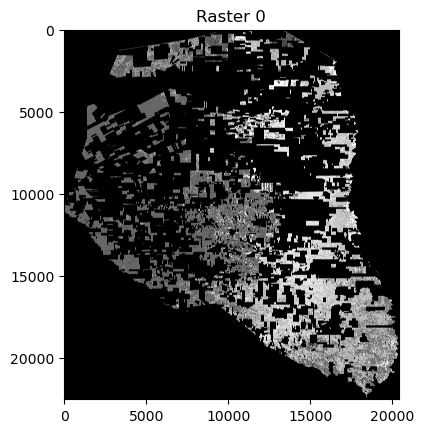

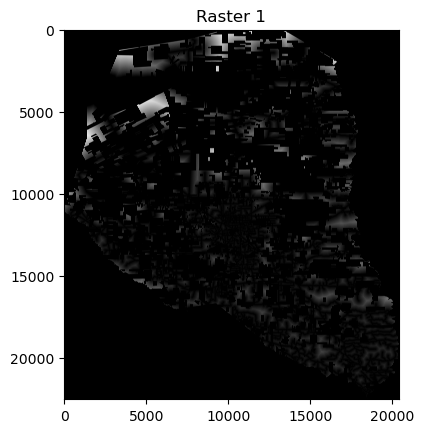

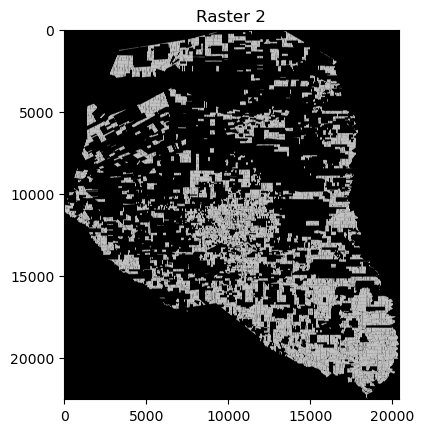

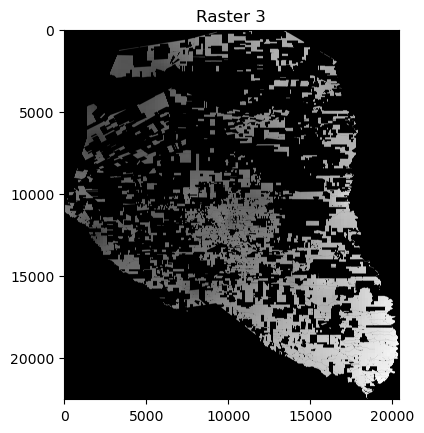

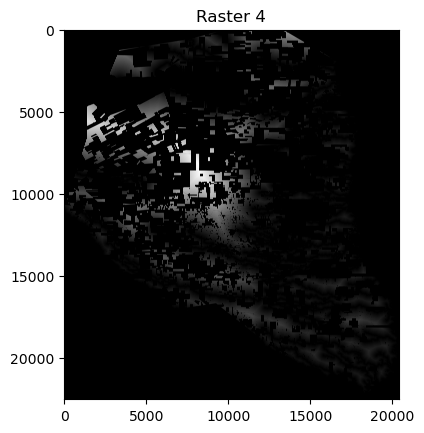

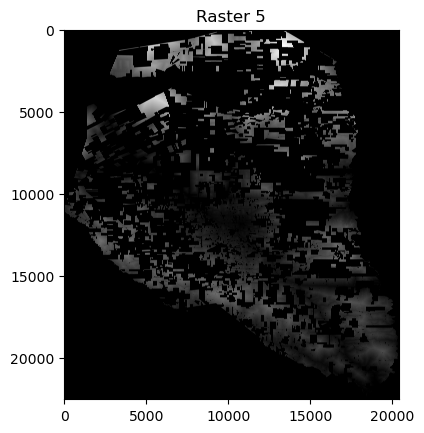

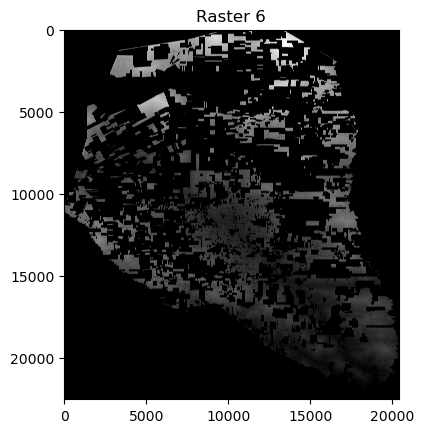

In [87]:
import matplotlib.pyplot as plt

for i, data_array in enumerate(feature_data_arrays):
    plt.figure()
    plt.imshow(data_array, cmap='gray')
    plt.title(f"Raster {i}")
    plt.show()




In [88]:
# Find the dimensions of all the raster data arrays
raster_shapes = [raster_data.shape for raster_data in feature_data_arrays]

# Check if all raster data arrays have the same dimensions
if len(set(raster_shapes)) > 1:
    print("There are mismatching dimensions:")
    for file_path, raster_shape in zip(raster_files, raster_shapes):
        print(f"File: {file_path}, Shape: {raster_shape}")
else:
    print("All raster data arrays have the same dimensions.")
    # Check the dimensions of all the raster data arrays
    for i, data_array in enumerate(feature_data_arrays):
        print(f"Raster {i}: {data_array.shape}")


All raster data arrays have the same dimensions.
Raster 0: (22512, 20381)
Raster 1: (22512, 20381)
Raster 2: (22512, 20381)
Raster 3: (22512, 20381)
Raster 4: (22512, 20381)
Raster 5: (22512, 20381)
Raster 6: (22512, 20381)


# Stack and Flatten Data

In [89]:

# NoData Value
no_data_value = -1

# Stack the flattened raster data
X_flat = np.column_stack(feature_data_flat)

# Remove rows with NoData values
valid_rows_X = ~(X_flat == no_data_value).any(axis=1)

# Create a new array X_cleaned by selecting only the rows in X_flat that correspond to the True elements in valid_rows_X
X_cleaned = X_flat[valid_rows_X]
 

To ensure your data cleaning steps have been applied correctly, you can check the following:

**NoData values have been removed:** You should confirm that there are no NoData values in your cleaned data. This can be done by asserting that there are no occurrences of no_data_value in X_cleaned 

In [90]:
assert not (X_cleaned == no_data_value).any()


These assertions will throw an error if there is a NoData value in X_cleaned 


In [91]:
# Apply the log transformation
log_X_cleaned = np.copy(X_cleaned)
log_X_cleaned[:, feature_labels.index('RIVER')] = np.log1p(log_X_cleaned[:, feature_labels.index('RIVER')])
log_X_cleaned[:, feature_labels.index('CITIES')] = np.log1p(log_X_cleaned[:, feature_labels.index('CITIES')])
log_X_cleaned[:, feature_labels.index('ROAD')] = np.log1p(log_X_cleaned[:, feature_labels.index('ROAD')])



-----------------
SOIL Skewness: 0.25029685858004924


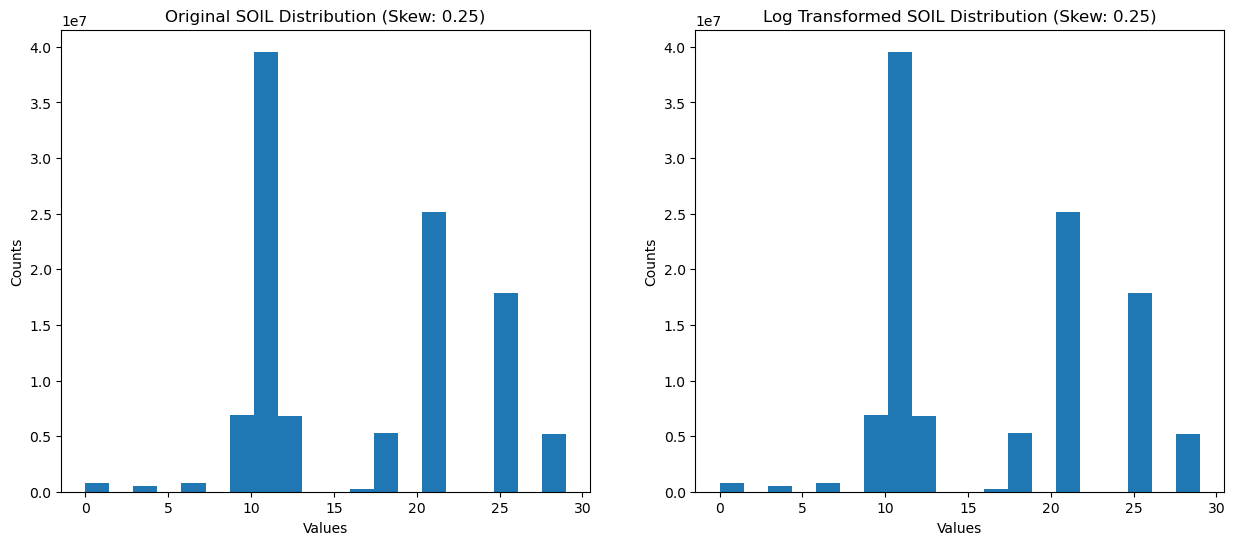

-----------------
ROAD Skewness: 2.4139349582907212


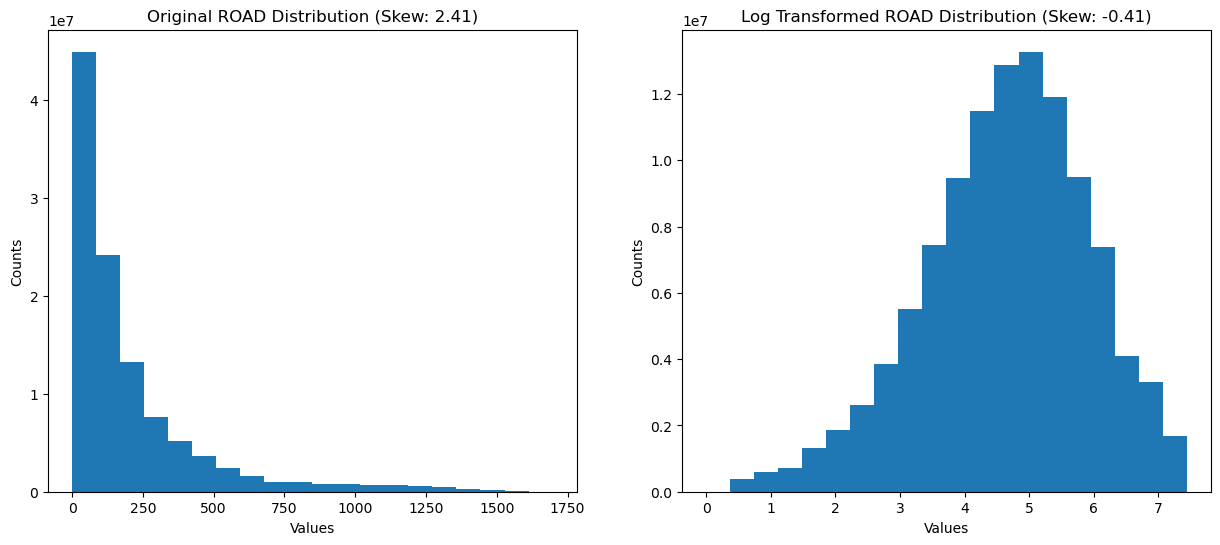

-----------------
SIM25 Skewness: -0.9029331688628788


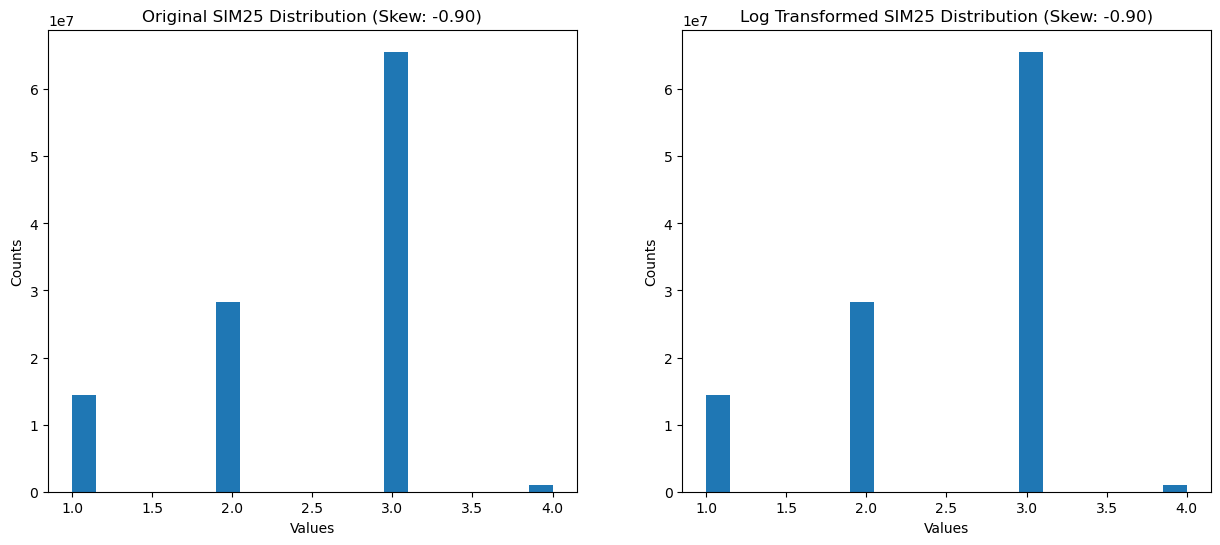

-----------------
PRECIPITATION Skewness: 0.3131549678071559


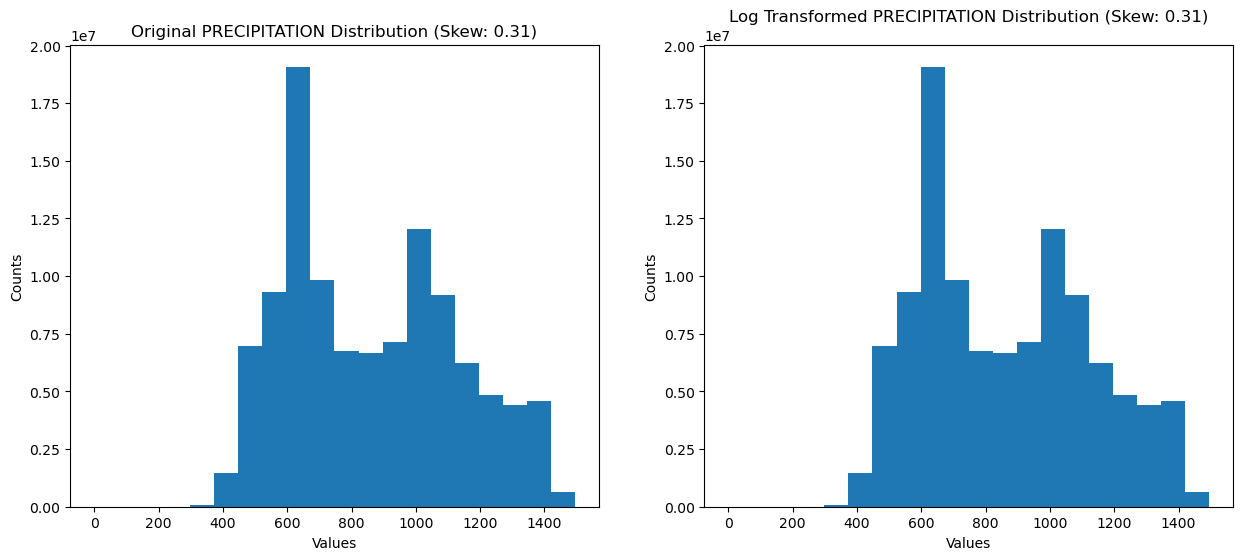

-----------------
RIVER Skewness: 2.118841157206764


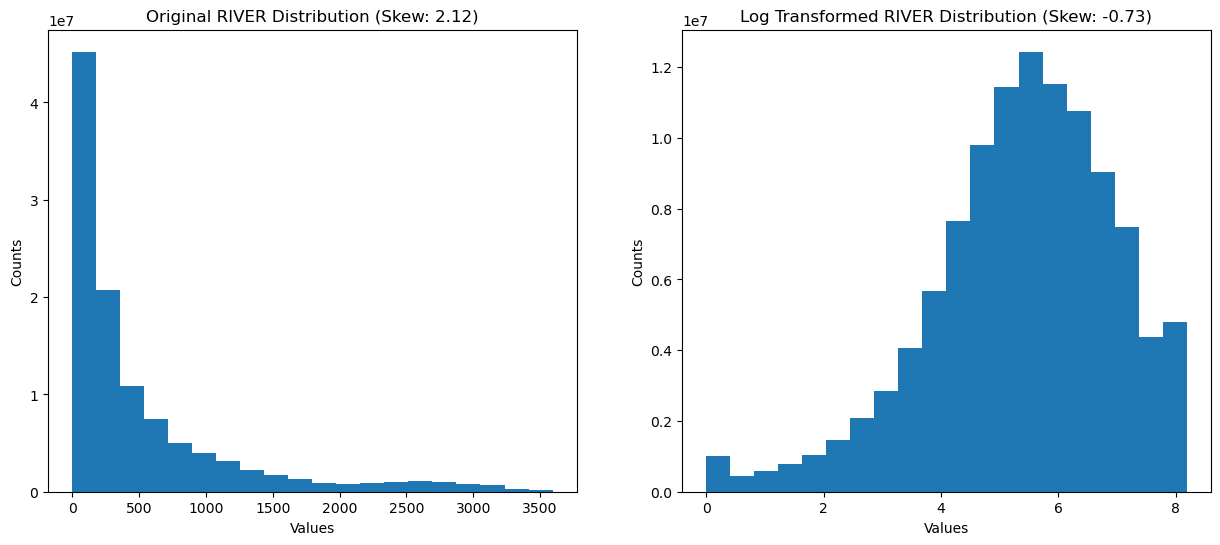

-----------------
CITIES Skewness: 1.3423418232015625


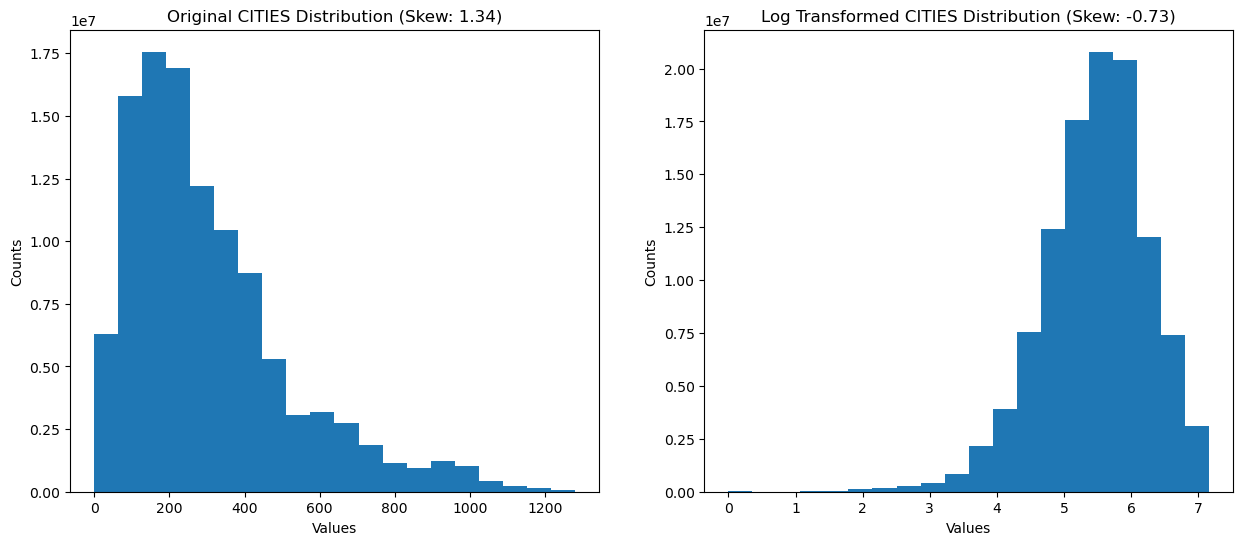

-----------------
PORTS Skewness: 0.9233228189682521


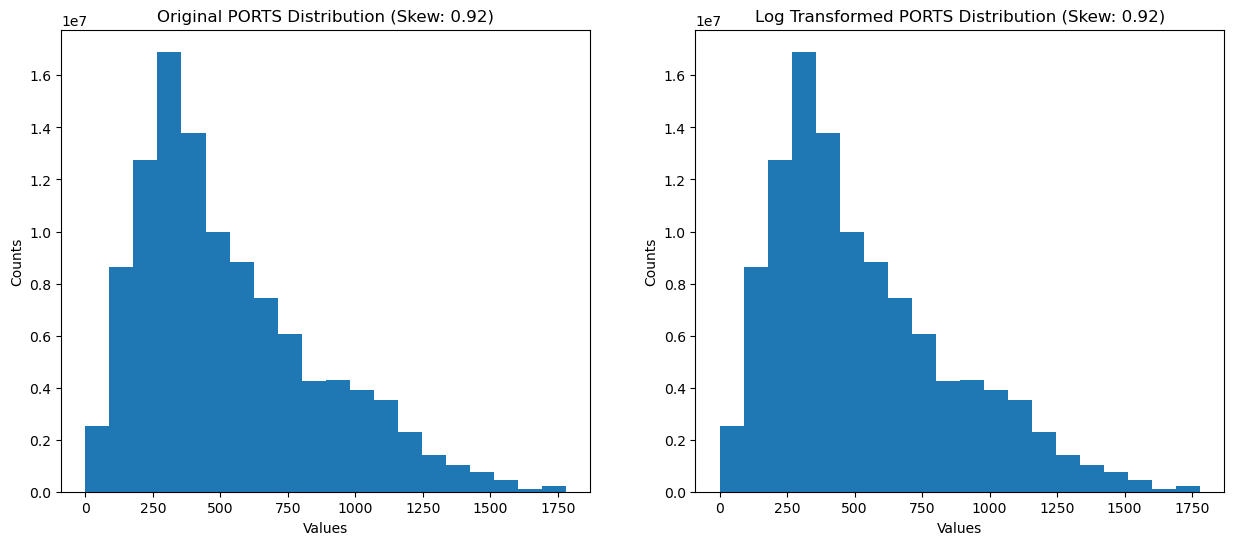

In [92]:

for i, feature in enumerate(feature_labels):
   # Compute skewness
    original_skew = skew(X_cleaned[:, i])
    transformed_skew = skew(log_X_cleaned[:, i])

    # Compute skewness
    feature_skew = skew(X_cleaned[:, i])
    
    print(f'-----------------\n{feature} Skewness: {feature_skew}')

    
   # Plot histogram
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original data histogram
    ax[0].hist(X_cleaned[:, i], bins=20)
    ax[0].set_title(f'Original {feature} Distribution (Skew: {original_skew:.2f})')
    ax[0].set_xlabel('Values')
    ax[0].set_ylabel('Counts')
    
    # Transformed data histogram
    ax[1].hist(log_X_cleaned[:, i], bins=20)
    ax[1].set_title(f'Log Transformed {feature} Distribution (Skew: {transformed_skew:.2f})')
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Counts')
    
    plt.show()


# Import Trained Model

In [76]:

# Load the model from the pickle file
model = joblib.load('/Users/romero61/github/PYFOREST-ML/05-outputs/BRFC-features-no-log/best_model.pkl')



# Probabilities For Deforestation Predict on Simulated Land Use Data

When you use the predict_proba method of a classifier, it returns a 2D array where each row corresponds to a data point (in your case, a pixel), and each column corresponds to a class. The value in each cell is the probability that the given data point belongs to the given class, according to the model.

In a binary classification problem, there are two classes: 0 and 1. Therefore, predict_proba returns a 2D array with two columns. The first column (index 0) contains the probabilities for class 0, and the second column (index 1) contains the probabilities for class 1.

So, when you do probabilities[:, 1], you are selecting all rows (:) and the second column (1). This gives you a 1D array containing the probabilities that each data point belongs to class 1.

In the context of the problem, class 1 might represent "deforested" areas. So class_1_probabilities would be an array where each value is the model's estimated probability that the corresponding pixel represents a deforested area.

In [93]:
# Predict probabilities on the new data for deforestation events
probabilities = model.predict_proba(log_X_cleaned)[:, 1]


In [42]:
np.unique(probabilities)

array([0.00000000e+00, 1.34769987e-05, 2.31382218e-05, ...,
       9.99842000e-01, 9.99877574e-01, 1.00000000e+00])

In [94]:

# Create a flat array filled with NoData values
probabilities_flat = np.full(X_flat.shape[0], no_data_value, dtype=np.float32)

# Replace the valid positions in the flat probabilities with the predicted probabilities
probabilities_flat[valid_rows_X] = probabilities

# Reshape the flat probabilities back into the shape of the original raster
probabilities_reshaped = probabilities_flat.reshape(feature_data_arrays[0].shape)




In [69]:
output_file = os.path.join(output_folder, "sim-25-all-feature-no-log-pred.tiff")

# Save the reshaped predictions as a new raster file
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(probabilities_reshaped, 1)